In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from stingray import Powerspectrum, Multitaper, Lightcurve
import scipy
from scipy import signal, interpolate
from scipy import signal
from scipy import fft
import seaborn as sns
sns.set_theme()
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
LSspec = importr("LSspec")
r_LSspecMT = robjects.r["LSspecMT"]
r_nfft = robjects.r["nfft"]
r_LSspec = robjects.r["LSspec"]

In [6]:
import pandas as pd

kepler_data = pd.read_csv("koi2133.csv")
times_kp = np.array(kepler_data["times"])
flux_kp = np.array(kepler_data["flux"])

FileNotFoundError: [Errno 2] No such file or directory: 'koi2133.csv'

In [5]:
kepler_lc = Lightcurve(time=times_kp, counts=flux_kp, err_dist="gauss")

/home/dhruv/repos/stingray/stingray/utils.py:126: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/dhruv/repos/stingray/stingray/utils.py:126: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


## Multitaper Lomb-Scargle

Use the Lomb-Scargle Periodogram in conjunction with the Multitapering concept for time-series with uneven sampling

Everthing works as before, just
- Create a `Lightcurve` with the unevenly sampled time-series
- Create a `Multitaper` object by passing it this `Lightcurve` object, with the desired value of NW, __just additionally pass the `lombscargle = True` keyword during instantiation.__

In [78]:
%%time
mtls = Multitaper(kepler_lc, low_bias=True, lombscargle=True, NW=20)

Using 38 DPSS windows for multitaper spectrum estimator
CPU times: user 32.6 s, sys: 1.02 s, total: 33.6 s
Wall time: 29.8 s


/home/dhruv/repos/stingray/stingray/utils.py:126: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [79]:
%%time
r_mtls_kp = r_LSspecMT(t = robjects.FloatVector(times_kp),
                    x = robjects.FloatVector(flux_kp - np.mean(flux_kp)),
                    w = 20/times_kp.shape[0],
                    k = 38)

freq_r_kp = np.array(r_mtls_kp[0])
P_r_kp = np.array(r_mtls_kp[1])

CPU times: user 27.7 s, sys: 484 ms, total: 28.1 s
Wall time: 26.1 s


In [80]:
print(freq_r_kp-mtls.freq)
print(P_r_kp - mtls.multitaper_norm_power)
print(np.mean(P_r_kp - mtls.multitaper_norm_power))

[0. 0. 0. ... 0. 0. 0.]
[ 8.80359656e-15 -3.06278947e-14  8.60392299e-14 ...  2.88494845e-14
  1.62433685e-14  2.96310935e-15]
7.920921443083819e-15


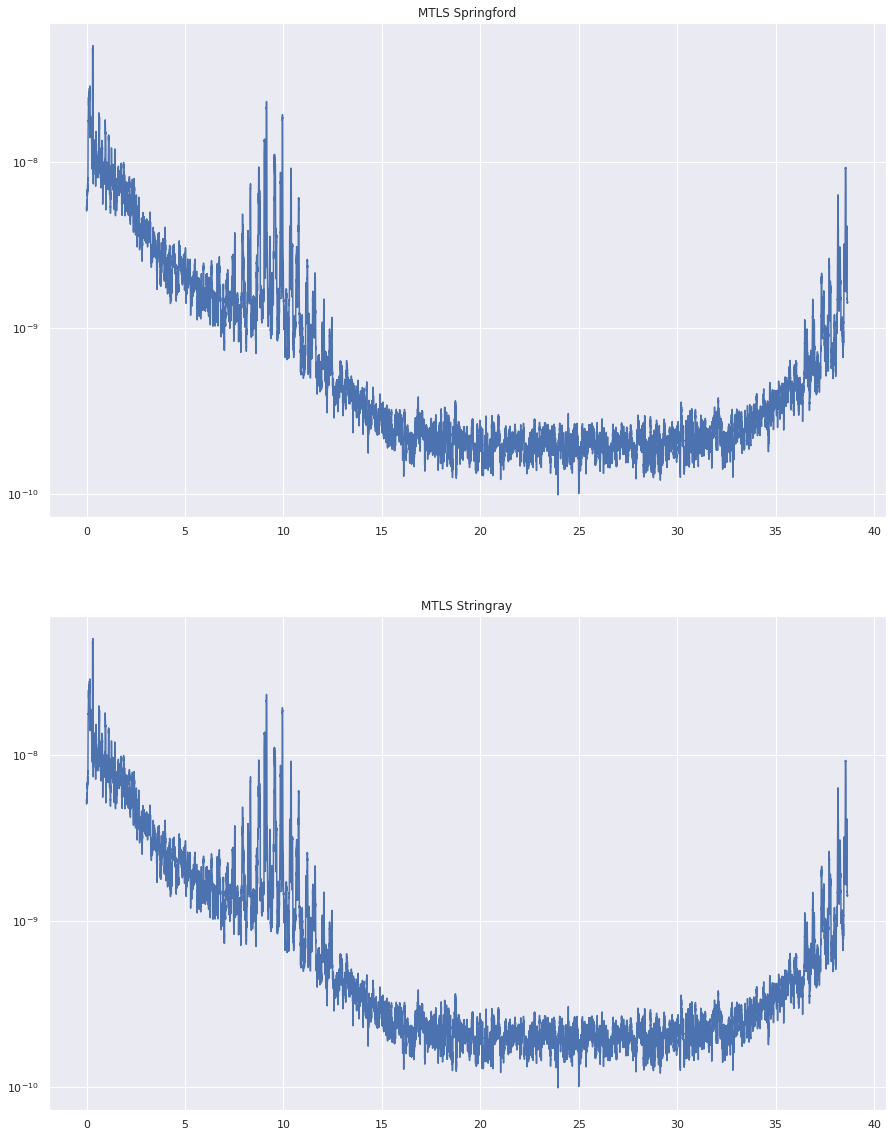

In [81]:
from matplotlib.gridspec import GridSpec
plt.figure(figsize=(15, 20))
gs = GridSpec(2, 1)
ax_mtls_r = plt.subplot(gs[0])
ax_mtls_r.plot(freq_r_kp, P_r_kp)
ax_mtls_r.set_title("MTLS Springford")
ax_mtls_r.set_yscale("log")

ax_mtls_sr = plt.subplot(gs[1], sharex=ax_mtls_r)
ax_mtls_sr.plot(mtls.freq, mtls.multitaper_norm_power)
ax_mtls_sr.set_title("MTLS Stringray")
ax_mtls_sr.set_yscale("log")

In [59]:
%%time
R_nfft = r_nfft(t = robjects.FloatVector(times_kp),
                x = robjects.FloatVector(flux_kp - np.mean(flux_kp)))

CPU times: user 358 ms, sys: 520 µs, total: 358 ms
Wall time: 356 ms


In [60]:
%%time
SR_nfft = mtls.nfft(times_kp, flux_kp - np.mean(flux_kp))

CPU times: user 302 ms, sys: 82 µs, total: 302 ms
Wall time: 301 ms


In [61]:
R_nfft = np.array(R_nfft)
R_nfft

array([-3.32635885e-12-0.j        , -1.91294524e-02-0.11980084j,
        1.08130434e-01-0.14925267j, ..., -1.41113469e-02-0.09239459j,
       -9.40554454e-02-0.07337648j,  8.07612868e-02+0.12644557j])

In [62]:
SR_nfft

array([-3.29353558e-12-0.j        , -1.91294524e-02-0.11980084j,
        1.08130434e-01-0.14925267j, ..., -1.41113469e-02-0.09239459j,
       -9.40554454e-02-0.07337648j,  8.07612868e-02+0.12644557j])

In [63]:
R_nfft - SR_nfft

array([-3.28232654e-14+0.00000000e+00j, -1.43243056e-13+3.43475248e-14j,
       -6.61276589e-14+3.56659147e-14j, ...,
        7.17028867e-13-5.72056291e-13j,  4.31571445e-13-5.09411957e-13j,
        6.79026280e-13+6.19171381e-13j])

In [64]:
np.mean(R_nfft - SR_nfft)

(2.615068921076525e-15-7.5968074323248e-16j)

In [84]:
rng = np.random.default_rng()
N = 1000

white_noise = rng.normal(loc=0.0, scale=7, size=N)
# white_noise_irregular = rng.normal(loc=0.0, scale=7, size=N)
white_noise_irregular = white_noise
start = 0.0
end = 9.0
time_irregular = np.linspace(start, end, N) + rng.normal(loc=0.0, scale=(end-start)/(3*N), size=N) # Generating uneven sampling times by adding white noise. Do tell a better way
time_irregular = np.sort(time_irregular)
time_regular = np.linspace(time_irregular[0], time_irregular[-1], N)
print(np.all(np.diff(time_irregular) > 0))
lc_nonuni = Lightcurve(time=time_irregular, counts=white_noise_irregular, err_dist="gauss")

True


In [85]:
%%time
r_white = r_LSspecMT(t = robjects.FloatVector(time_irregular),
                    x = robjects.FloatVector(white_noise_irregular - np.mean(white_noise_irregular)),
                    w = 4/time_irregular.shape[0],
                    k = 7)

freq_r_white = np.array(r_white[0])
P_r_white = np.array(r_white[1])

CPU times: user 186 ms, sys: 0 ns, total: 186 ms
Wall time: 184 ms


In [86]:
%%time
mtls_white = Multitaper(lc_nonuni, lombscargle=True, low_bias=True, NW=4)


Using 7 DPSS windows for multitaper spectrum estimator
CPU times: user 418 ms, sys: 59.9 ms, total: 478 ms
Wall time: 476 ms


/home/dhruv/repos/stingray/stingray/utils.py:126: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [87]:
mtls_white.multitaper_norm_power.shape

(1000,)

In [73]:
print(mtls_white.freq - freq_r_white)
print(P_r_white - mtls_white.multitaper_norm_power)
print(np.mean(P_r_white - mtls_white.multitaper_norm_power))

[0. 0. 0. ... 0. 0. 0.]
[ 9.24578652e-07  4.05717828e-07 -6.39303483e-07 ... -4.00194578e-07
 -4.28641263e-07 -1.66546657e-06]
-9.480537570668695e-08


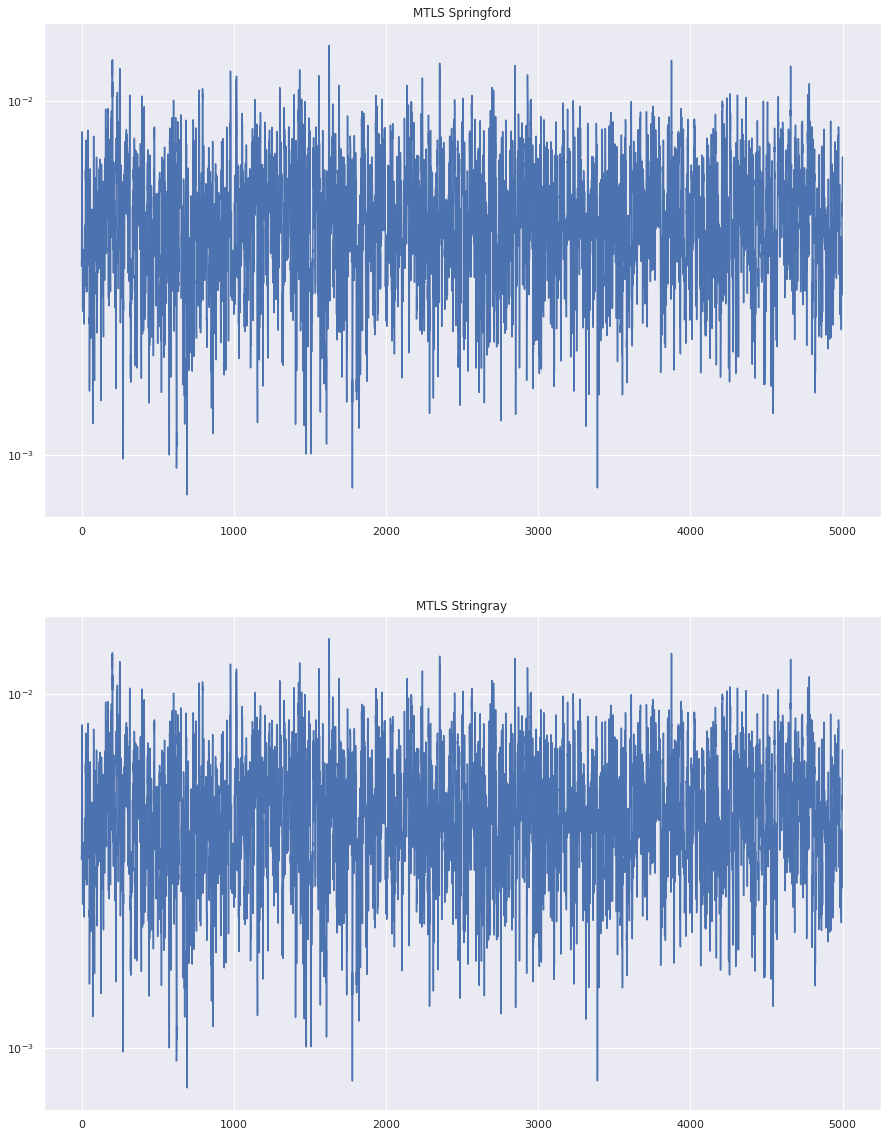

In [71]:
plt.figure(figsize=(15, 20))
gs = GridSpec(2, 1)
ax_mtls_r = plt.subplot(gs[0])
ax_mtls_r.plot(freq_r_white, P_r_white)
ax_mtls_r.set_title("MTLS Springford")
ax_mtls_r.set_yscale("log")

ax_mtls_sr = plt.subplot(gs[1], sharex=ax_mtls_r)
ax_mtls_sr.plot(mtls_white.freq, mtls_white.multitaper_norm_power)
ax_mtls_sr.set_title("MTLS Stringray")
ax_mtls_sr.set_yscale("log")

## Difference in Normalization is show here

In [9]:
from cycler import cycler

def plot(freqs, powers, labels=None, xscale="linear", yscale="log", title=None, dpi=150, figsize=[6.4*1.4, 4.8*1.4]):
    """Plot the Power vs Frequency pairs on the same axis
    
    Parameters
    ----------
    
    freqs: list or iterable
        A list containing the mid-bin frequencies of the corresponding PSD's in ``powers``
    
    powers: list or iterable
        A list containing the PSD amplitudes at the corresponding mid-bin frequiences in ``freqs``
    """
    
    fig = plt.figure(dpi=dpi, figsize=figsize)
    plt.rc('lines', linewidth=0.7)
    plt.rc('axes', prop_cycle=(cycler('color', sns.color_palette("bright"))))
    
    if labels is not None and len(labels) != len(freqs):
        print("Number of labels should be the same the number of curves, not using any labels.")
        labels = [None for _ in range(len(freqs))]
    elif labels == None:
        labels = [None for _ in range(len(freqs))]
    
    for freq, power, label in zip(freqs, powers, labels):
        plt.plot(freq, power, label=label)
    
    plt.xlabel('Frequency')
    plt.ylabel('PSD')
    plt.yscale(yscale)
    plt.xscale(xscale)
    plt.grid(True, which="both")
    plt.title(title)
    plt.legend()
    plt.show()

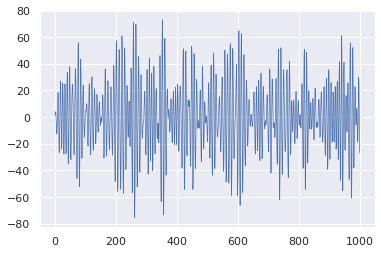

In [23]:
np.random.seed(1) # For consistency
coeff = np.array([2.7607, -3.8106, 2.6535, -0.9238])
ar4 = np.r_[1, -coeff] # For use with scipy.signal
N = 1000
Fs=1

freq_analytical, h = signal.freqz(b=1.0, a=ar4, worN=N, fs=1) #  True PSD of AR(4)
psd_analytical = (h * h.conj()).real

data = signal.lfilter([1.0], ar4, np.random.randn(N)) # 1000 AR(4) data samples.

times = np.arange(N)

std = 2.0
err = np.ones_like(data)*std # Don't know what the errors will be.

lc = Lightcurve(time=times, counts=data, err_dist='gauss', dt=1, err=err)
lc.plot()

### seems to be "leahy" normalized

/home/dhruv/repos/stingray/stingray/utils.py:126: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/dhruv/repos/stingray/stingray/utils.py:126: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Using 7 DPSS windows for multitaper spectrum estimator
Using 7 DPSS windows for multitaper spectrum estimator


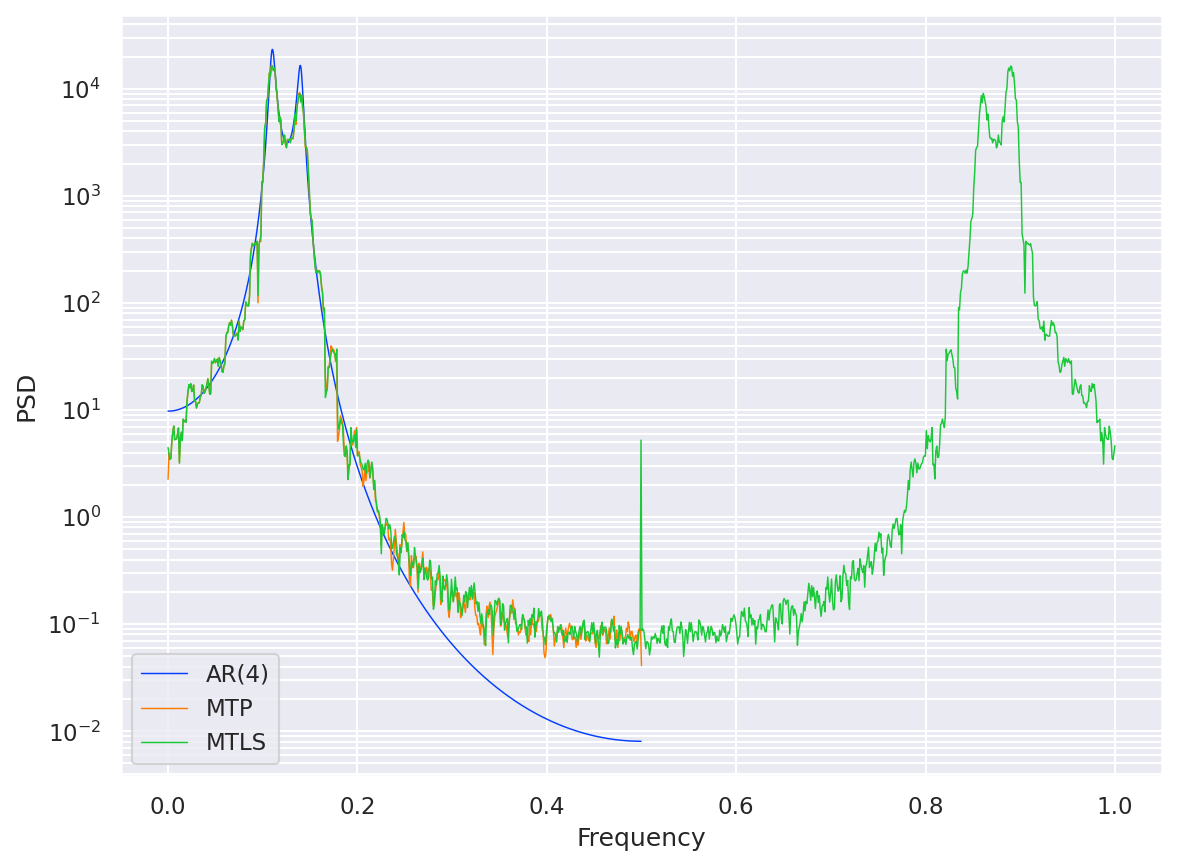

In [24]:
mtp = Multitaper(lc, low_bias=True, adaptive=False, NW=4, norm="leahy")
mtls = Multitaper(lc, low_bias=True, adaptive=False, NW=4, lombscargle=True)
plot(freqs=[freq_analytical, mtp.freq, mtls.freq],
    powers=[psd_analytical, mtp.power, mtls.unnorm_power],
    labels=["AR(4)", "MTP", "MTLS"])

### But is not consistenent

In [10]:
from stingray.simulator import simulator, models

sim = simulator.Simulator(N=1024, mean=0.5, dt=0.125)

Using 7 DPSS windows for multitaper spectrum estimator
Using 7 DPSS windows for multitaper spectrum estimator


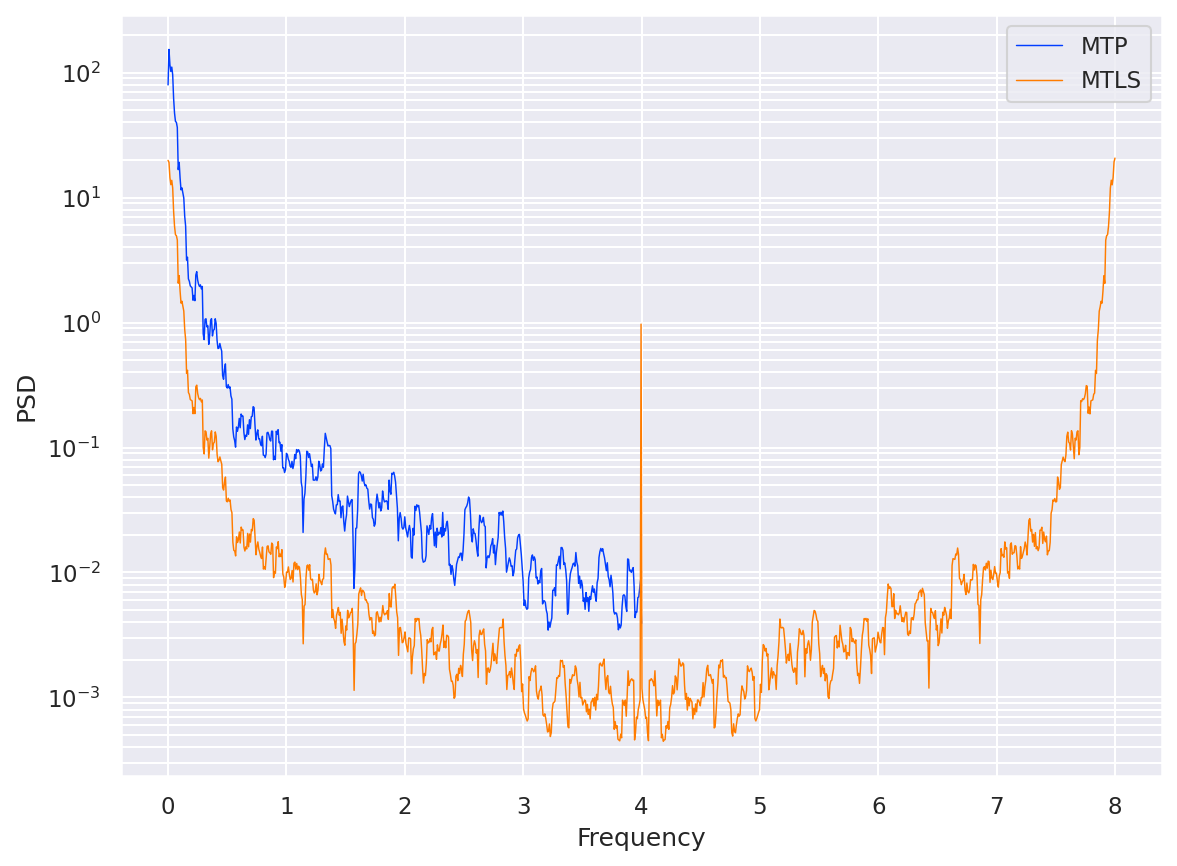

In [11]:
lc2 = sim.simulate(2)

mtp2 = Multitaper(lc2, low_bias=True, adaptive=False, norm="Leahy")
mtls2 = Multitaper(lc2, low_bias=True, adaptive=False, lombscargle=True)

plot(freqs=[mtp2.freq, mtls2.freq],
    powers=[mtp2.power, mtls2.unnorm_power],
    labels=["MTP", "MTLS"])

/home/dhruv/repos/stingray/stingray/utils.py:126: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/dhruv/repos/stingray/stingray/utils.py:126: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Using 7 DPSS windows for multitaper spectrum estimator
Using 7 DPSS windows for multitaper spectrum estimator


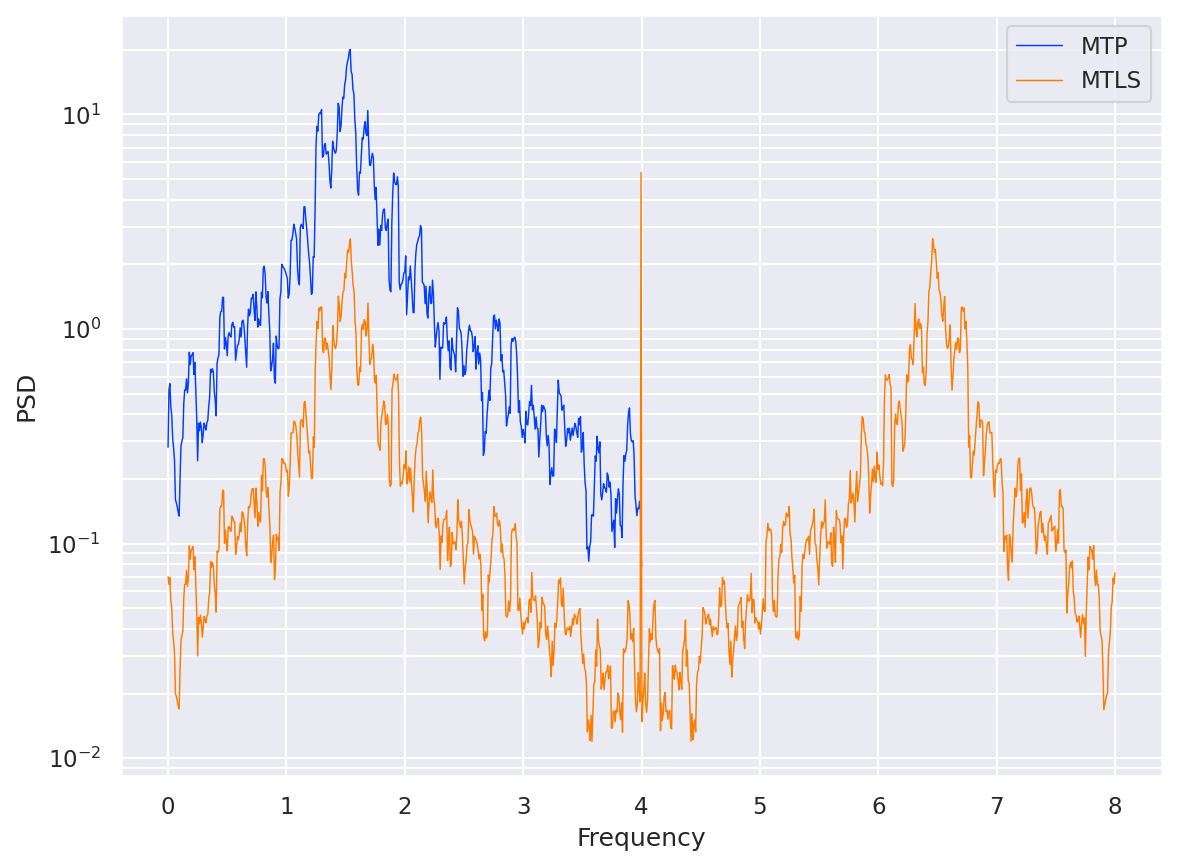

In [12]:
lc3 = sim.simulate('generalized_lorentzian', [1.5, .2, 1.2, 1.4])
Fs = 1/lc3.dt

mtp3 = Multitaper(lc3, low_bias=True, adaptive=False, norm="Leahy")
mtls3 = Multitaper(lc3, low_bias=True, adaptive=False, lombscargle=True)

plot(freqs=[mtp3.freq, mtls3.freq],
    powers=[mtp3.power, mtls3.unnorm_power],
    labels=["MTP", "MTLS"])